# Natural Language Processing: Word Embeddings with Reddit AITA Data

---

<div class="alert alert-success">  
    
### Learning Objectives 

* Understand how word embeddings capture meaning in social media text
* Learn to train and apply FastText embeddings on Reddit data
* Explore moral and ethical dimensions encoded in language
* Analyze relationship dynamics and social biases in AITA posts
* Develop skills to uncover hidden patterns in online discourse
</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
💡 **Tip**: How to do something a bit more efficiently or effectively.<br>
⚠️ **Warning:** Heads-up about tricky stuff or common mistakes.<br>

### Sections
1. [Recall Bag-of-Words?](#section0)
2. [Understanding Word Embeddings](#section1)
3. [Exploring AITA Data](#section2)
4. [Training FastText on Reddit Data](#section3)
5. [Analyzing Judgment and Relationship Terms](#section4)
6. [Reddit-Specific Word Analogies](#section5)
7. [Uncovering Bias in Online Discourse](#section6)

**Why this matters: Traditional word embeddings are a foundational technique. They’re quick to train, and interpretable at the word level.**

<a id='section1'></a>

## Recall Bag-of-Words?

Recall from last week that the bag-of-words model represents the text as numbers using **word frequency counts**. Each position in the matrix corresponds to a particular word, and the matrix specifies how many times each word occurs.

<img src='../../img/bow-illustration-2.png' alt="BoW" width="500">

The model does not take into account any relationships between the words. In other words, it has no understanding that "bank" and "banker" are closely related. **Each word is treated independently from every other word**.  This limits the model's ability to understand language.

### Enter Word Embeddings

Word embeddings were born from the idea to make the numbers describing words more useful. It is an approach in which we try to capture the **semantic similarity** between words by describing them with many numbers. Each of these numbers captures some 'dimension' or 'aspect' of meaning.

In word embeddings, each word is represented by a **dense vector** of numbers. So not a list with lots of 0s and some 1s, but a list full of complex numbers. 

### Word Embeddings = Machine Learning

In word embeddings, we treat semantic relations as a Machine Learning (ML) problem. Essentially, we teach a **neural network** how to predict the similarity of words by throwing in all of the words in our corpus, and training it to identify patterns and relationships between them based on their contextual usage.

This process involves looking at words that appear closely together within a sentence or document, and assume that this mean they have similar meanings. That's all! Surprisingly, this is enough to capture all kinds of semantic and syntactic features in the data.

The idea is that the neural network will learn to encode each word as a **vector of numbers (a word embedding)** such that words that appear in similar contexts will have similar vectors.

<img src='../../img/bow-illustration-3.png' alt="BoW" width="500">

Note that the numbers in vectors in these kinds of models are sometimes called **weights** or **parameters**.

Bottom line: Word embeddings models yield vectors that are both much shorter, and much more information-rich than Bag of Words models.

In [ ]:
import gensim.downloader as api

# Load a smal pre-trained word embeddings model
glove = api.load('glove-wiki-gigaword-50')

In [3]:
# Look at the vector for a word
print("Embedding for 'bank':")
print(glove['bank'])

# Check nearest neighbors
print("\nNearest neighbors for 'bank':")
for word, score in glove.most_similar('bank', topn=5):
    print(f"  {word:10s} {score:.3f}")

Embedding for 'bank':
[ 0.66488  -0.11391   0.67844   0.17951   0.6828   -0.47787  -0.30761
  0.17489  -0.70512  -0.55022   0.1514    0.10214  -0.45063  -0.33069
  0.056133  1.2271    0.55607  -0.68297   0.037364  0.70266   1.9093
 -0.61483  -0.83329  -0.3023   -1.1118   -1.55      0.2604    0.22957
 -1.0375   -0.31789   3.5091   -0.25871   1.0151    0.65927  -0.18231
 -0.75859  -0.30927  -0.91678   1.0633   -0.66761  -0.37464  -0.29143
  0.65606  -0.44642  -0.075495 -1.0552   -0.60501   0.73582   1.0139
 -0.27749 ]

Nearest neighbors for 'bank':
  banks      0.870
  securities 0.800
  banking    0.797
  investment 0.785
  exchange   0.781


<a id='section1'></a>

## Training Word Embeddings

Remember, the basic idea of all word embeddings models is that **words that occur closely together tend to have similar meanings.** 

That means we can learn what words mean based on the **context** in which they appear. We use a **context window** to determine how many words we consider "closely together". In this example, we use a window of 2 words on each side of the target word.

<img src='../../img/target_word.png' alt="Target word" width="500">

### Word2Vec

Probably the most famous word embeddings model is Word2Vec. It trains a **neural network** to perform one of two tasks: either predicting a target word given its context, or predicting the context given a target word. 

<img src='../../img/word2vec-model.png' alt="word2vec" width="550">

The training aims to create word embeddings that capture semantic and syntactic relationships between words. For example, after training, the vectors for "king" and "queen" should be similar because they often appear in similar contexts (they're both royalty, both appear in similar types of sentences, etc.).

### FastText for Reddit Posts

FastText is a word embeddings approach based on Word2Vec, but using **character n-grams**, making it ideal for Reddit because:

- **It handles typos**: "definately" → still understood as "definitely"
- **It processes Reddit acronyms**: Can learn representations for YTA, NTA, etc.
- **it captures morphology**: Understands relationships between "asshole," "assholish," "assholery"

Let's train a model on our own data to see that even smaller datasets can yield models that capture semantically meaningful relationships.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import FastText, Word2Vec
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

<a id='section2'></a>
## Exploring AITA Data

Let's start by loading and exploring our Reddit AITA dataset. This dataset contains posts where people describe interpersonal conflicts and ask the community to judge whether they were "the asshole" in the situation.

In [3]:
# Load the Reddit AITA data
df = pd.read_csv('../../data/aita_top_subs.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (10000, 23)
Columns: ['idint', 'idstr', 'created', 'self', 'nsfw', 'author', 'title', 'url', 'selftext', 'score', 'subreddit', 'distinguish', 'textlen', 'num_comments', 'flair_text', 'flair_css_class', 'augmented_at', 'augmented_count', 'created_date', 'year', 'month', 'day_of_week', 'text_length']


In [4]:
# Some posts might be '[deleted]' or very short; filter lightly
df['selftext'] = df['selftext'].astype(str).str.strip().dropna()
df = df[df['selftext'].str.len() > 20].reset_index(drop=True)

print(f"Total posts after filtering: {len(df):,}")

Total posts after filtering: 8,243


### Preprocessing Reddit Text

Reddit text requires special preprocessing to handle its unique characteristics:

In [7]:
def preprocess_reddit_text(text):
    """Clean and tokenize Reddit text for embedding training."""
    # Convert to lowercase
    text = text.lower()
    
    # Keep common Reddit acronyms intact
    reddit_acronyms = {'aita', 'yta', 'nta', 'esh', 'nah', 'wibta', 'mil', 'fil', 'sil', 'bil'}
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Handle Reddit-specific formatting
    text = re.sub(r'/u/\w+|/r/\w+', '', text)  # Remove user/subreddit mentions
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)  # Remove markdown links
    
    # Basic tokenization (keeping contractions)
    tokens = re.findall(r"\b[a-z]+(?:'[a-z]+)?\b|[a-z]+", text)
    
    # Filter out very short tokens except Reddit acronyms
    tokens = [t for t in tokens if len(t) > 2 or t in reddit_acronyms]
    
    return tokens

# Test the preprocessing
sample = df['selftext'].iloc[1]
print(f"Processed: {preprocess_reddit_text(sample)[:20]}")

Processed: ['brother', 'law', 'sammy', 'lost', 'his', 'home', 'shortly', 'after', 'his', 'divorce', 'months', 'ago', 'moved', 'with', 'and', 'brought', 'his', 'twin', 'daughters', 'olivia']


In [8]:
# Prepare corpus for training
print("Preparing corpus for embedding training...")

# Combine title and selftext for richer context
df['combined_text'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')

# Tokenize all texts
corpus = df['combined_text'].apply(preprocess_reddit_text).tolist()

# Remove empty documents
corpus = [doc for doc in corpus if len(doc) > 0]

print(f"Total documents: {len(corpus)}")
print(f"Average tokens per document: {np.mean([len(doc) for doc in corpus]):.0f}")

# Sample processed document
print(f"\nSample tokenized document (first 20 tokens):")
print(corpus[1][:20])

Preparing corpus for embedding training...
Total documents: 8243
Average tokens per document: 344

Sample tokenized document (first 20 tokens):
['aita', 'for', 'telling', 'wife', 'the', 'lock', "daughter's", 'door', 'does', 'not', 'get', 'removed', 'til', 'brother', 'inlaw', 'and', 'his', 'daughters', 'are', 'out']


🔔 **Question**: Why do you think combining titles with post content might improve our embeddings?

<a id='section3'></a>
## Training FastText on Reddit Data

Now let's train a FastText model on our AITA corpus. FastText is particularly well-suited for Reddit data because it can handle out-of-vocabulary words by using character n-grams.

### FastText vs Word2Vec

While Word2Vec treats each word as an atomic unit, FastText breaks words into character n-grams:
- Word2Vec: "mother-in-law" → single token (if in vocabulary)
- FastText: "mother-in-law" → {"mot", "oth", "the", "her", ...} (character trigrams)

This means FastText can generate embeddings even for words it hasn't seen before!

In [9]:
# Train FastText model
print("Training FastText model on AITA corpus...")
print("This may take a few minutes...")

# FastText parameters optimized for Reddit data
model = FastText(
    sentences=corpus,
    vector_size=100,      # Dimensionality of embeddings
    window=5,             # Context window size
    min_count=5,          # Ignore words appearing less than 5 times
    min_n=3,              # Min character n-gram
    max_n=6,              # Max character n-gram
    sg=1,                 # Use Skip-gram (better for smaller datasets)
    epochs=10,            # Training iterations
    seed=42
)

print(f"Model trained! Vocabulary size: {len(model.wv)}")
print(f"Vector dimensions: {model.wv.vector_size}")

Training FastText model on AITA corpus...
This may take a few minutes...
Model trained! Vocabulary size: 12773
Vector dimensions: 100


In [10]:
# Test the model with Reddit-specific terms
test_words = ['aita', 'asshole', 'justified', 'mother', 'wedding', 'family']

print("Checking if words are in vocabulary:")
for word in test_words:
    if word in model.wv:
        print(f"✓ '{word}' - vector shape: {model.wv[word].shape}")
    else:
        print(f"✗ '{word}' - not in vocabulary")

# FastText can handle OOV words!
print("\nTesting out-of-vocabulary words:")
oov_word = 'assholery'  # Likely not in training data
print(f"'{oov_word}' vector (generated via subwords): {model.wv[oov_word][:5]}...")

Checking if words are in vocabulary:
✓ 'aita' - vector shape: (100,)
✓ 'asshole' - vector shape: (100,)
✓ 'justified' - vector shape: (100,)
✓ 'mother' - vector shape: (100,)
✓ 'wedding' - vector shape: (100,)
✓ 'family' - vector shape: (100,)

Testing out-of-vocabulary words:
'assholery' vector (generated via subwords): [-0.21273111 -0.3283325   0.16996875  0.3208379  -0.08837257]...


### Comparing with Pre-trained Models

Let's load a pre-trained model to compare with our Reddit-specific embeddings:

In [12]:
# Compare similar words for "family" in both models
word = 'aita'

print(f"\nMost similar to '{word}' in AITA-trained model:")
for similar_word, score in model.wv.most_similar(word, topn=5):
    print(f"  {similar_word}: {score:.3f}")

print(f"\nMost similar to '{word}' in pre-trained GloVe:")
for similar_word, score in glove.most_similar(word, topn=5):
    print(f"  {similar_word}: {score:.3f}")


Most similar to 'aita' in AITA-trained model:
  aitah: 0.882
  wibta: 0.693
  amita: 0.621
  awta: 0.602
  ita: 0.600

Most similar to 'aita' in pre-trained GloVe:
  shaab: 0.789
  albu: 0.715
  dhari: 0.711
  madinat: 0.702
  alil: 0.694


🔔 **Question**: How do the similar words differ between the AITA-trained model and the general pre-trained model? What does this tell us about the AITA discourse?

<a id='section4'></a>
## Analyzing Judgment and Relationship Terms

AITA posts revolve around moral judgments and interpersonal relationships. Let's explore how our embeddings capture these concepts.

In [13]:
# Explore judgment-related terms
judgment_terms = ['asshole', 'justified', 'wrong', 'right', 'reasonable', 'selfish', 'entitled']

for term1 in judgment_terms[:3]:
    similarities = []
    for term2 in judgment_terms:
        if term1 != term2 and term1 in model.wv and term2 in model.wv:
            sim = model.wv.similarity(term1, term2)
            similarities.append((term2, sim))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    print(f"\n'{term1}' most similar to:")
    for word, score in similarities[:3]:
        print(f"  {word}: {score:.3f}")


'asshole' most similar to:
  justified: 0.627
  selfish: 0.614
  wrong: 0.598

'justified' most similar to:
  asshole: 0.627
  wrong: 0.620
  reasonable: 0.525

'wrong' most similar to:
  justified: 0.620
  asshole: 0.598
  right: 0.488


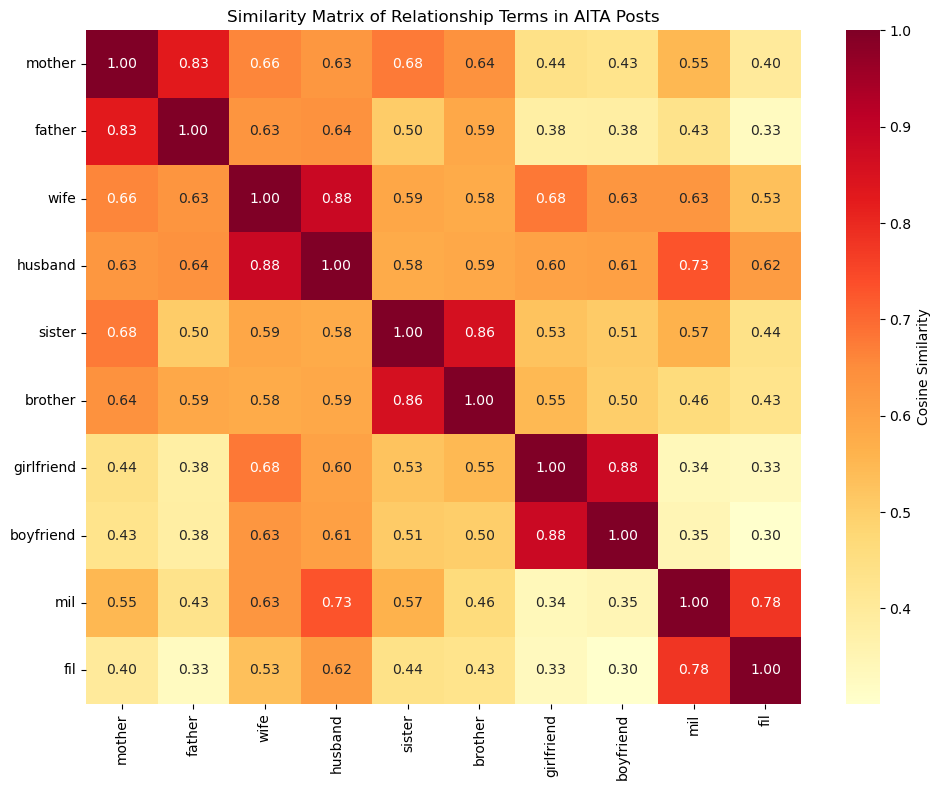

In [14]:
# Analyze relationship terms
relationship_terms = ['mother', 'father', 'wife', 'husband', 'sister', 'brother', 
                     'girlfriend', 'boyfriend', 'mil', 'fil']  # MIL = mother-in-law

# Create a heatmap of relationship similarities
available_terms = [t for t in relationship_terms if t in model.wv]
n_terms = len(available_terms)
similarity_matrix = np.zeros((n_terms, n_terms))

for i, term1 in enumerate(available_terms):
    for j, term2 in enumerate(available_terms):
        similarity_matrix[i, j] = model.wv.similarity(term1, term2)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, 
            xticklabels=available_terms,
            yticklabels=available_terms,
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Similarity Matrix of Relationship Terms in AITA Posts')
plt.tight_layout()
plt.show()

## Visualizing Word Embeddings

Each embedding is just a list of numbers (a vector). You can think of those numbers as the coordinates of a dot in space, or as the tip of an arrow starting at the origin. 

<img src='../../img/vector_arrow_point.png' alt="word embeddings vectors" width="250">


If you connect two points, the arrow between them gives you a direction — an axis. The remarkable thing is that many of these directions line up with meaningful relationships: tense, gender, country–capital, and so on.

<img src='../../img/vector.png' alt="word embeddings vectors" width="600">

You may be asking: how are we visualizing this? After all, when we work with word embeddings, we are dealing with high-dimension space (in our case: 100 dimensions). This is impossible to visualize!

However, we can reduce these dimensions using algorithms such as t-SNE.


## Visualize a neighborhood (2D)

We’ll select a handful of **anchor words** and their neighbors, then reduce to 2D with t‑SNE.  

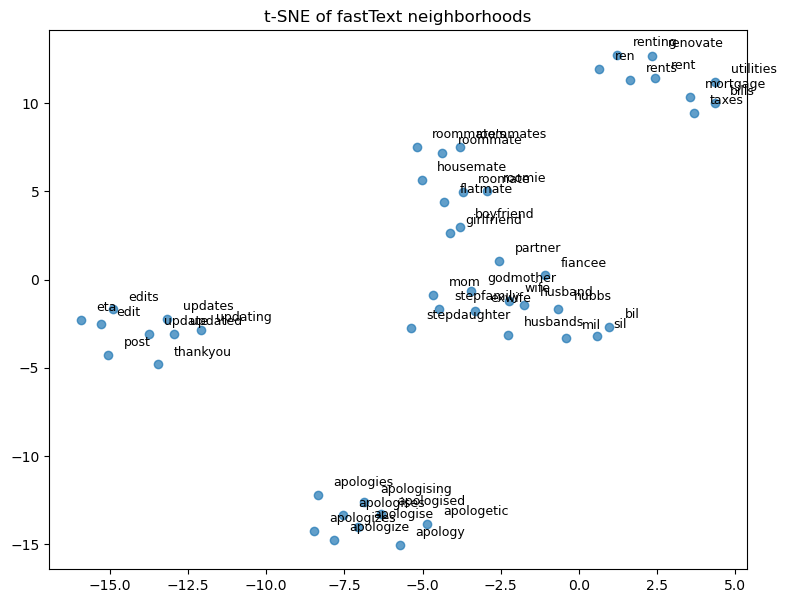

In [15]:

import itertools
from collections import defaultdict

anchors = ["husband","wife","roommate","apology","rent","update"]
points = {}
for a in anchors:
    if a in model.wv:
        points[a] = model.wv[a]
        for n,_ in model.wv.most_similar(a, topn=8):
            if n not in points and n in model.wv:
                points[n] = model.wv[n]

words = list(points.keys())
X = np.vstack([points[w] for w in words])

# t-SNE can be slow if too many points; set perplexity based on size
perp = min(30, max(5, len(words)//5))
tsne = TSNE(n_components=2, perplexity=perp, random_state=42, init="random", learning_rate="auto")
X2 = tsne.fit_transform(X)

# Simple scatter plot (matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(9,7))
plt.scatter(X2[:,0], X2[:,1], alpha=0.7)
for i, w in enumerate(words):
    plt.text(X2[i,0]+0.5, X2[i,1]+0.5, w, fontsize=9)
plt.title("t-SNE of fastText neighborhoods")
plt.show()


<a id='section5'></a>
## Reddit-Specific Word Analogies

Word analogies in the AITA context can reveal interesting patterns about social relationships and moral reasoning. The classic example:

- `V(King) - V(Man) + V(Woman) ≈ V(Queen)`
- or "man is to woman as king is to queen"

### What “is to” means in analogies

When we say: "man is to woman as king is to ?"

We mean: **the relationship between man and woman should be the same as the relationship between king and the missing word.**

<img src='../../img/analogy.png' alt="word embeddings analogies" width="300">

So we want a word vector that captures the difference (king − man) and then applies that difference to woman.

Let's explore AITA-specific analogies:

In [16]:
def analogy(model, pos, neg, topn=5):
    try:
        return model.wv.most_similar(positive=pos, negative=neg, topn=topn)
    except KeyError as e:
        return [("OOV in analogy", 0.0)]

tests = [
    (["husband", "woman"], ["man"], "husband - man + woman"),
    (["boyfriend", "woman"], ["man"], "boyfriend - man + woman"),
    (["bride", "birthday"], ["wedding"], "bride - wedding + birthday"),
]
for pos, neg, desc in tests:
    print(f"\nAnalogy: {desc}")
    for w, s in analogy(model, pos, neg):
        print(f"  {w:>15}  {s:.3f}")



Analogy: husband - man + woman
             wife  0.760
              mil  0.678
              sil  0.635
         husbands  0.608
            hubbs  0.590

Analogy: boyfriend - man + woman
       girlfriend  0.700
       boyfriends  0.695
      girlfriends  0.625
          roomate  0.621
         befriend  0.619

Analogy: bride - wedding + birthday
        birthdays  0.577
             bday  0.562
          present  0.542
            merry  0.538
        sleepover  0.525


In [ ]:
# EXERCISE: Moral Judgment Analogies in AITA
# Fill in the blanks with AITA-relevant moral judgment terms (e.g., 'justified', 'reasonable', 'selfish', 'entitled', etc.)

# Example: ____ is to ____ as ____ is to ____ ?
# Try: justified : reasonable :: selfish : ?
# Try: honest : truthful :: liar
# Try: nta : justified :: yta : selfish

term_a = 'justified'      # CHANGE THIS
term_b = 'reasonable'     # CHANGE THIS
term_c = 'selfish'        # CHANGE THIS

if all(word in model.wv for word in [term_a, term_b, term_c]):
    result = model.wv.most_similar(positive=[term_b, term_c], negative=[term_a], topn=3)
    print(f"\n{term_a} : {term_b} :: {term_c} : ?")
    for word, score in result:
        print(f"  {word} ({score:.3f})")
else:
    print("One or more terms not in vocabulary. Try different words.")


justified : reasonable :: selfish : ?
  unreasonable (0.653)
  selfishly (0.637)
  stingy (0.566)


<a id='section6'></a>
## Uncovering Bias in Online Discourse

Word embeddings trained on Reddit data inevitably capture the biases present in online discussions. Let's examine gender bias, age bias, and moral judgment patterns in AITA posts.

### Semantic Axis

To investigate bias in word embeddings, we need a way to represent a concept like gender or morality as a direction in the vector space. We do this by constructing a semantic axis.

The idea is simple:
- Individual words (man, woman, he, she) are points in the embedding space.
- If we collect a set of words that belong to one side of a concept (e.g., female words) and another set for the opposite side (e.g., male words), we can find the average vector for each set.
- The line connecting these two averages gives us a single axis that captures the concept.

Formally:
- $\mathbf{W}{\text{plus}} = {w{1}^{+}, w_{2}^{+}, …, w_{i}^{+}}$ (words on the “positive” side)
- $\mathbf{W}{\text{minus}} = {w{1}^{-}, w_{2}^{-}, …, w_{j}^{-}}$ (words on the “negative” side)

We compute the mean of each set:
- $\mathbf{V}{\text{plus}} = \frac{1}{i}\sum{1}^{i}w_{i}^{+}$
- $\mathbf{V}{\text{minus}} = \frac{1}{j}\sum{1}^{j}w_{j}^{-}$

Then we take their difference:
- $\mathbf{V}{\text{axis}} = \mathbf{V}{\text{plus}} - \mathbf{V}_{\text{minus}}$

This vector $\mathbf{V}_{\text{axis}}$ is our semantic axis. To see how a particular word relates to this concept, we project it onto the axis using cosine similarity:

$score(w) = \cos(v_{w}, \mathbf{V}_{\text{axis}})$

A positive score means the word lies closer to the $\mathbf{V}{\text{plus}}$ end, while a negative score means it leans toward $\mathbf{V}{\text{minus}}$.

### TL;DR

A semantic axis is constructed by:
	1.	Choosing two sets of words that represent opposite sides of a concept
	2.	Averaging the embeddings in each set
	3.	Subtracting one average from the other to create a single axis vector


In [20]:
def create_semantic_axis(positive_words, negative_words, model):
    """Create a semantic axis from two sets of pole words."""
    # Get embeddings for available words
    pos_vectors = [model.wv[w] for w in positive_words if w in model.wv]
    neg_vectors = [model.wv[w] for w in negative_words if w in model.wv]
    
    if not pos_vectors or not neg_vectors:
        return None
    
    # Calculate means
    pos_mean = np.mean(pos_vectors, axis=0)
    neg_mean = np.mean(neg_vectors, axis=0)
    
    # Return the difference (semantic axis)
    return pos_mean - neg_mean

def project_on_axis(word, model, axis):
    """Project a word onto a semantic axis."""
    if word not in model.wv or axis is None:
        return None
    
    word_vector = model.wv[word]
    # Normalize and compute cosine similarity
    return np.dot(word_vector, axis) / (np.linalg.norm(word_vector) * np.linalg.norm(axis))

### Gender Axis

Let’s start by constructing a semantic axis from two sets of gendered words. We collect a group of female-associated words (she, her, woman, mother, …) and a group of male-associated words (he, him, man, father, …). We then calculate the average embedding of each group.

The line connecting these two average points is our gender axis:
- The positive side points toward “woman / female.”
- The negative side points toward “man / male.”

This way, instead of relying on a single word pair, we use the centroid of each group, which gives us a more stable and general axis.

<img src='../../img/semantic_axis.png' alt="gender axis" width="300">

In [25]:
# Create gender axis
female_terms = ['she', 'her', 'woman', 'girl', 'wife', 'mother', 'daughter', 'sister']
male_terms = ['he', 'him', 'man', 'boy', 'husband', 'father', 'son', 'brother']

gender_axis = create_semantic_axis(female_terms, male_terms, model)

We define “positive” as leaning female and “negative” as leaning male because the gender axis itself was constructed as woman − man. 

If we had built it the other way around, the signs would swap. The important part isn’t the plus or minus sign itself! It's that words with similar gender associations cluster on the same side of the axis.

Gender associations in conflict roles:
(Positive = more female-associated, Negative = more male-associated)
------------------------------------------------------------
aggressor       +0.118 (leans female)
victim          -0.121 (leans male)
instigator      +0.064 (leans female)
peacemaker      -0.148 (leans male)
mediator        -0.014 (leans male)
complainer      +0.129 (leans female)
supporter       -0.049 (leans male)
critic          +0.091 (leans female)


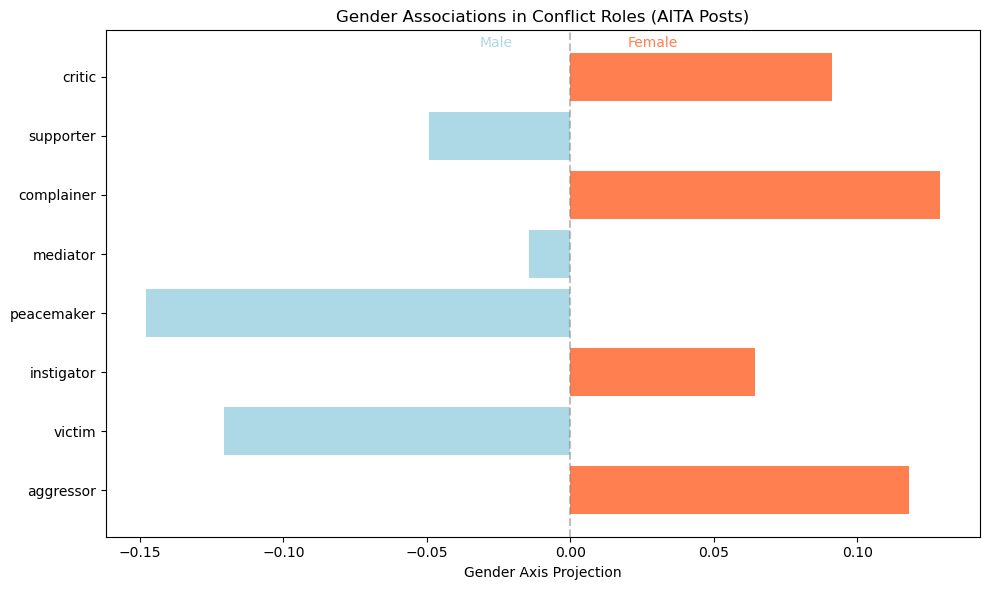

In [22]:
# Analyze gender bias in relationship conflict terms
conflict_roles = ['aggressor', 'victim', 'instigator', 'peacemaker', 'mediator', 
                  'complainer', 'supporter', 'critic']

print("Gender associations in conflict roles:")
print("(Positive = more female-associated, Negative = more male-associated)")
print("-" * 60)

role_projections = {}
for role in conflict_roles:
    projection = project_on_axis(role, model, gender_axis)
    if projection is not None:
        role_projections[role] = projection
        direction = "female" if projection > 0 else "male"
        print(f"{role:15} {projection:+.3f} (leans {direction})")

# Visualize the results
if role_projections:
    plt.figure(figsize=(10, 6))
    roles = list(role_projections.keys())
    values = list(role_projections.values())
    colors = ['coral' if v > 0 else 'lightblue' for v in values]
    
    plt.barh(roles, values, color=colors)
    plt.xlabel('Gender Axis Projection')
    plt.title('Gender Associations in Conflict Roles (AITA Posts)')
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.text(0.02, len(roles)-0.5, 'Female', fontsize=10, color='coral')
    plt.text(-0.02, len(roles)-0.5, 'Male', fontsize=10, color='lightblue', ha='right')
    plt.tight_layout()
    plt.show()

### Moral Axis

Next, let's map some action words onto a "moral axis".
- We define the axis: build an average direction over pairs like reasonable–unreasonable, fair–unfair.
- We project the actions: for each verb (e.g., refused, helped), compute its cosine projection onto that axis:
$\text{score}(w) = \cos(\textbf{w}, \textbf{moral\_axis})$

Interpretation:
- Positive → closer to “justified” usage in your corpus
- Negative → closer to “unjustified”


In [26]:
# Create moral judgment axis
justified_terms = ['justified', 'reasonable', 'right', 'fair', 'understandable']
unjustified_terms = ['unjustified', 'unreasonable', 'wrong', 'unfair', 'selfish']

moral_axis = create_semantic_axis(justified_terms, unjustified_terms, model)

In [28]:
# Analyze moral judgments for different actions
actions = ['refused', 'demanded', 'asked', 'yelled', 'ignored', 'helped', 
           'apologized', 'confronted', 'avoided', 'explained']

action_projections = {}
for action in actions:
    projection = project_on_axis(action, model, moral_axis)
    if projection is not None:
        action_projections[action] = projection
        judgment = "justified" if projection > 0 else "unjustified"
        print(f"{action:15} {projection:+.3f} (leans {judgment})")

refused         -0.108 (leans unjustified)
demanded        -0.110 (leans unjustified)
asked           +0.017 (leans justified)
yelled          -0.317 (leans unjustified)
ignored         -0.125 (leans unjustified)
helped          +0.062 (leans justified)
apologized      -0.202 (leans unjustified)
confronted      -0.100 (leans unjustified)
avoided         -0.085 (leans unjustified)
explained       +0.021 (leans justified)


### Cultural Axis

AITA posts often involve cultural differences. Let's create a semantic axis to explore how different family and social concepts are positioned culturally:

In [29]:
# Create your own semantic axis for a concept you're interested in
# For example: traditional vs. modern, individual vs. collective, etc.

# Define your pole words
traditional_terms = ['traditional', 'conservative', 'customs', 'heritage']
modern_terms = ['modern', 'progressive', 'contemporary', 'liberal']

# Create the axis
cultural_axis = create_semantic_axis(traditional_terms, modern_terms, model)

# Test it on family-related concepts
family_concepts = ['marriage', 'wedding', 'parenting', 'discipline', 'respect', 
                   'independence', 'obligation', 'duty', 'freedom']

print("Cultural associations in family concepts:")
for concept in family_concepts:
    projection = project_on_axis(concept, model, cultural_axis)
    if projection is not None:
        print(f"{concept:15} {projection:+.3f}")

Cultural associations in family concepts:
marriage        +0.305
wedding         +0.409
parenting       +0.116
discipline      +0.089
respect         +0.251
independence    -0.045
obligation      +0.159
duty            -0.012
freedom         +0.181


### Gender vs Moral Judgment

So far we’ve learned:
- How to build axes in embedding space (e.g., gender: woman − man, moral: justified − unjustified).
- How to project words onto a single axis to see which side they lean toward.
- How analogies and projections let us peek into what kinds of relationships are encoded in the embeddings.

Now, we combine these ideas into a 2-dimensional map:
- The x-axis is our gender axis (negative = male, positive = female).
- The y-axis is our moral axis (negative = unjustified, positive = justified).
- By plotting AITA-relevant terms (victim, liar, helper, etc.) in this space, we can see at a glance which concepts the model tends to associate with male vs. female, and justified vs. unjustified.

This is a simple but powerful way to show how embeddings can encode social biases and moral judgments.

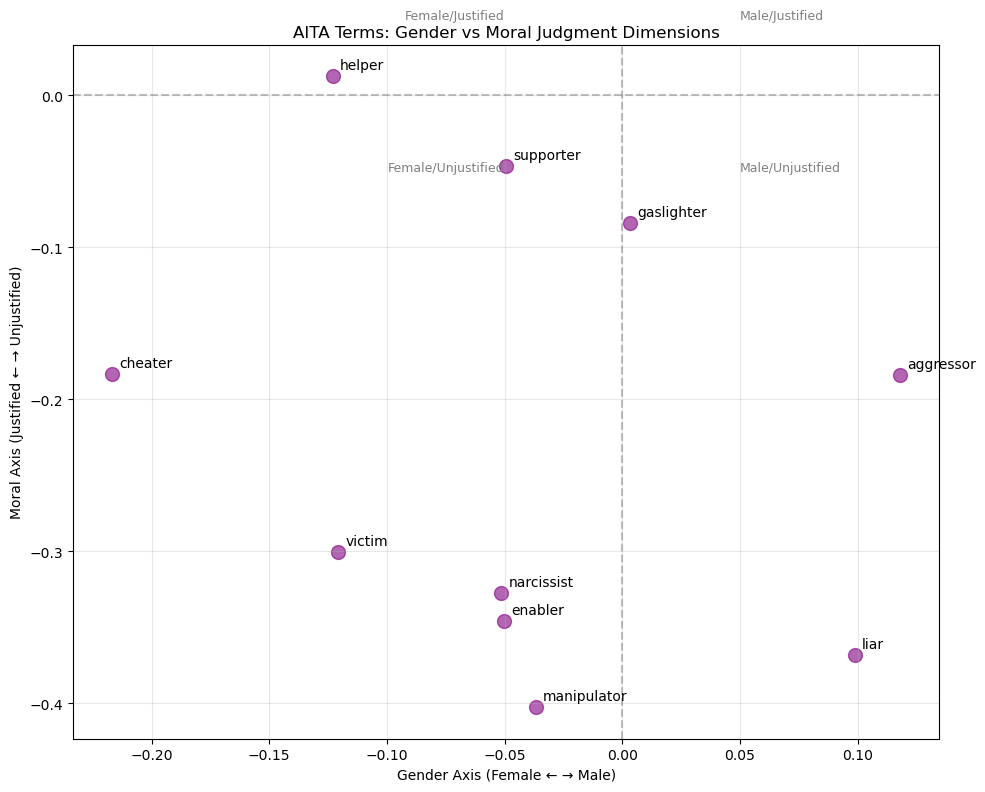

In [31]:
# Create a two-axis plot: Gender vs Moral Judgment
analysis_terms = ['victim', 'aggressor', 'liar', 'cheater', 'helper', 'supporter',
                  'narcissist', 'enabler', 'gaslighter', 'manipulator']

# Calculate projections on both axes
gender_projections = []
moral_projections = []
plot_terms = []

for term in analysis_terms:
    g_proj = project_on_axis(term, model, gender_axis)
    m_proj = project_on_axis(term, model, moral_axis)
    
    if g_proj is not None and m_proj is not None:
        gender_projections.append(g_proj)
        moral_projections.append(m_proj)
        plot_terms.append(term)

if plot_terms:
    plt.figure(figsize=(10, 8))
    plt.scatter(gender_projections, moral_projections, s=100, alpha=0.6, c='purple')
    
    for i, term in enumerate(plot_terms):
        plt.annotate(term, (gender_projections[i], moral_projections[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.xlabel('Gender Axis (Female ← → Male)')
    plt.ylabel('Moral Axis (Justified ← → Unjustified)')
    plt.title('AITA Terms: Gender vs Moral Judgment Dimensions')
    
    # Add quadrant labels
    plt.text(0.05, 0.05, 'Male/Justified', fontsize=9, color='gray', ha='left')
    plt.text(-0.05, 0.05, 'Female/Justified', fontsize=9, color='gray', ha='right')
    plt.text(0.05, -0.05, 'Male/Unjustified', fontsize=9, color='gray', ha='left')
    plt.text(-0.05, -0.05, 'Female/Unjustified', fontsize=9, color='gray', ha='right')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

🔔 **Question**: What patterns do you notice in how terms cluster along these dimensions? What might this tell us about the biases in how AITA community discusses conflicts?

## References

1. [FastText](https://arxiv.org/abs/1607.04606): Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). Enriching word vectors with subword information. *Transactions of the Association for Computational Linguistics, 5*, 135-146.
2. [Word2Vec](https://arxiv.org/abs/1301.3781): Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space.
3. [Bias in embeddings](https://arxiv.org/abs/1607.06520): Bolukbasi, T., Chang, K. W., Zou, J. Y., Saligrama, V., & Kalai, A. T. (2016). Man is to computer programmer as woman is to homemaker? Debiasing word embeddings.
4. [Reddit and social media NLP](https://aclanthology.org/2020.emnlp-main.303/): Proferes, N., Jones, N., Gilbert, S., Fiesler, C., & Zimmer, M. (2021). Studying Reddit: A systematic overview of disciplines, approaches, methods, and ethics.

<div class="alert alert-success">

## ❗ Key Points

* **FastText excels at informal text**: By using character n-grams, FastText handles the misspellings, slang, and abbreviations common in Reddit posts better than traditional Word2Vec.
* **Context shapes meaning**: Words that appear together in AITA posts (like "justified" and "reasonable") develop similar vector representations, capturing the moral discourse of the community.
* **Domain-specific embeddings reveal community values**: Training on AITA data captures relationship dynamics and moral judgments specific to this community's discussions.
* **Biases are embedded in language**: Gender associations, moral judgments, and cultural biases present in the posts are reflected in the learned embeddings.
* **Semantic axes uncover hidden patterns**: By constructing axes for concepts like gender or moral judgment, we can systematically analyze biases in how different terms are discussed.

</div>